In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def important_values(path):
    
    # Read in stock price data, get shape
    stock_price_df = pd.read_csv(path)
    t = np.shape(stock_price_df)[0]-1
    n = np.shape(stock_price_df)[1]-1

    # Build returns matrix
    stock_price = stock_price_df.values[:,1:]
    X = np.ndarray(shape=(t,n))
    for i in range(t):
        for j in range(n):
            X[i,j] = (stock_price[i,j]/stock_price[i+1,j])-1

    # Get mean vector and covariance matrix 
    X_df = pd.DataFrame(X)
    m = X_df.mean().values
    v = (X_df.var().values)**0.5
    C = ((n-1)/n)*(X_df.cov().values)
    
    # Get important values for portfolio choice
    e = np.ones(n)
    C_inv = np.linalg.inv(C)
    q_ee = e@C_inv@e
    q_em = e@C_inv@m
    q_me = m@C_inv@e
    q_mm = m@C_inv@m
    
    return e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm

def portfolio_stats(path,w):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    r_p = np.dot(w,m)
    v_p = (w@C@w)**0.5
    return np.array([r_p,v_p])

In [3]:
def min_var_portfolio(path,r):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    lambda_1 = (q_mm-q_me*r)/(q_ee*q_mm-q_em*q_me)
    lambda_2 = (q_ee*r-q_em)/(q_ee*q_mm-q_em*q_me)
    return C_inv@(lambda_1*e+lambda_2*m)

def min_var_portfolio_stats(path,r):
    w_mvp = min_var_portfolio(path,r)
    return portfolio_stats(path,w_mvp)

def global_min_var_portfolio(path):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    r_gmv = (q_em+q_me)/(2*q_ee)
    return min_var_portfolio(path,r_gmv)

def global_min_var_portfolio_stats(path):
    w_gmv = global_min_var_portfolio(path)
    return portfolio_stats(path,w_gmv)

def efficient_frontier(path,r_min,r_max):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    size = int((r_max-r_min)*1000+1)
    r_grid = np.linspace(r_min,r_max,size)
    v_grid = np.zeros(len(r_grid))
    for i in range(len(r_grid)):
        v_grid[i] = ((q_ee*r_grid[i]**2-(q_em+q_me)*r_grid[i]+q_mm)/(q_ee*q_mm-q_em*q_me))**0.5
    return r_grid, v_grid

def dw_dr(path):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    return (C_inv@(q_ee*m-q_me*e))/(q_ee*q_mm-q_em*q_me)

In [4]:
def tangency_portfolio(path,r_f):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    r_tan = ((q_em+q_me)*r_f-2*q_mm)/(2*q_ee*r_f-q_em-q_me)
    return min_var_portfolio(path,r_tan)

def tangency_portfolio_stats(path,r_f):
    w_tan = tangency_portfolio(path,r_f)
    return portfolio_stats(path,w_tan)

def max_sharpe_ratio(path,r_f):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    r_tan = ((q_em+q_me)*r_f-2*q_mm)/(2*q_ee*r_f-q_em-q_me)
    v_tan = ((q_ee*r_tan**2-(q_em+q_me)*r_tan+q_mm)/(q_ee*q_mm-q_em*q_me))**0.5
    return (r_tan-r_f)/v_tan

def optimal_portfolio(path,r_f,alpha):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    r_tan = ((q_em+q_me)*r_f-2*q_mm)/(2*q_ee*r_f-q_em-q_me)
    v_tan = ((q_ee*r_tan**2-(q_em+q_me)*r_tan+q_mm)/(q_ee*q_mm-q_em*q_me))**0.5
    msr = (r_tan-r_f)/v_tan
    w_f = (r_tan-r_f-msr**2/alpha)/(r_tan-r_f)
    w_opt = (1-w_f)*tangency_portfolio(path,r_f)
    return w_f, w_opt

def optimal_portfolio_stats(path,r_f,alpha):
    e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(path)
    r_tan = ((q_em+q_me)*r_f-2*q_mm)/(2*q_ee*r_f-q_em-q_me)
    v_tan = ((q_ee*r_tan**2-(q_em+q_me)*r_tan+q_mm)/(q_ee*q_mm-q_em*q_me))**0.5
    msr = (r_tan-r_f)/v_tan
    r_opt = r_f+msr**2/alpha
    v_opt = msr/alpha
    return np.array([r_opt,v_opt])

def optimal_utility(path,r_f,alpha):
    stats = optimal_portfolio_stats(path,r_f,alpha)
    return stats[0]-alpha*stats[1]**2/2

In [5]:
sp500_t10_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\sp500-t10-10y.csv"
sp500_t25_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\sp500-t25-10y.csv"
sp500_t50_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\sp500-t50-10y.csv"
sp500_t100_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\sp500-t100-10y.csv"
nk225_t10_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\nk225-t10-10y.csv"
nk225_t25_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\nk225-t25-10y.csv"
nk225_t50_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\nk225-t50-10y.csv"
nk225_t100_10y = r"C:\Users\zhubr\Desktop\ECON 251\stock-price-data\nk225-t100-10y.csv"

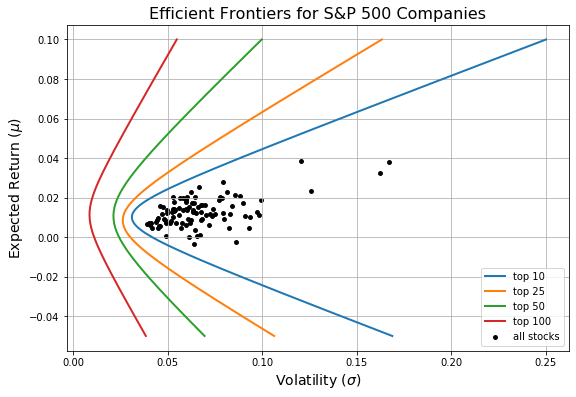

In [6]:
r_min = -0.05
r_max = 0.1
r_grid_10_US, v_grid_10_US = efficient_frontier(sp500_t10_10y,r_min,r_max)
r_grid_25_US, v_grid_25_US = efficient_frontier(sp500_t25_10y,r_min,r_max)
r_grid_50_US, v_grid_50_US = efficient_frontier(sp500_t50_10y,r_min,r_max)
r_grid_100_US, v_grid_100_US = efficient_frontier(sp500_t100_10y,r_min,r_max)

plt.figure(figsize=(9,6))
plt.plot(v_grid_10_US,r_grid_10_US,lw=2,label="top 10")
plt.plot(v_grid_25_US,r_grid_25_US,lw=2,label="top 25")
plt.plot(v_grid_50_US,r_grid_50_US,lw=2,label="top 50")
plt.plot(v_grid_100_US,r_grid_100_US,lw=2,label="top 100")
e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(sp500_t100_10y)
plt.scatter(v,m,c='k',s=15,label="all stocks")
plt.title("Efficient Frontiers for S&P 500 Companies",size=16)
plt.xlabel("Volatility ($\sigma$)",size=14)
plt.ylabel("Expected Return ($\mu$)",size=14)
plt.grid()
plt.legend(loc="lower right")
plt.savefig(r"C:\Users\zhubr\Desktop\ECON 251\figures\sp500-ef.png")
plt.show()

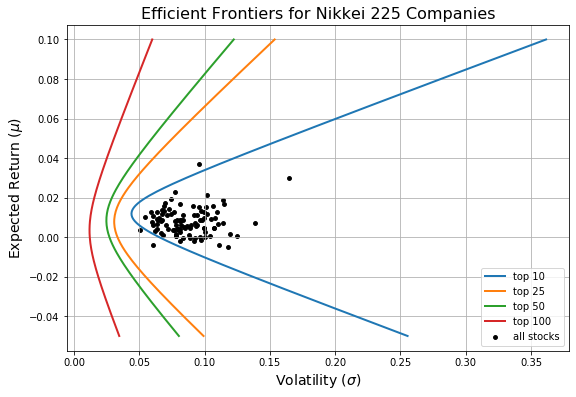

In [7]:
r_min = -0.05
r_max = 0.1
r_grid_10_JP, v_grid_10_JP = efficient_frontier(nk225_t10_10y,r_min,r_max)
r_grid_25_JP, v_grid_25_JP = efficient_frontier(nk225_t25_10y,r_min,r_max)
r_grid_50_JP, v_grid_50_JP = efficient_frontier(nk225_t50_10y,r_min,r_max)
r_grid_100_JP, v_grid_100_JP = efficient_frontier(nk225_t100_10y,r_min,r_max)

plt.figure(figsize=(9,6))
plt.plot(v_grid_10_JP,r_grid_10_JP,lw=2,label="top 10")
plt.plot(v_grid_25_JP,r_grid_25_JP,lw=2,label="top 25")
plt.plot(v_grid_50_JP,r_grid_50_JP,lw=2,label="top 50")
plt.plot(v_grid_100_JP,r_grid_100_JP,lw=2,label="top 100")
e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(nk225_t100_10y)
plt.scatter(v,m,c='k',s=15,label="all stocks")
plt.title("Efficient Frontiers for Nikkei 225 Companies",size=16)
plt.xlabel("Volatility ($\sigma$)",size=14)
plt.ylabel("Expected Return ($\mu$)",size=14)
plt.grid()
plt.legend(loc="lower right")
plt.savefig(r"C:\Users\zhubr\Desktop\ECON 251\figures\nk225-ef.png")
plt.show()

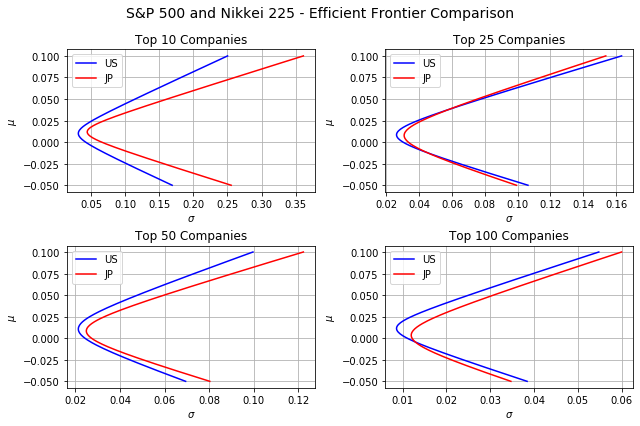

In [8]:
plt.figure(figsize=(9,6))

plt.subplot(2,2,1)
plt.plot(v_grid_10_US,r_grid_10_US,c='b',label="US")
plt.plot(v_grid_10_JP,r_grid_10_JP,c='r',label="JP")
plt.title("Top 10 Companies")
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(v_grid_25_US,r_grid_25_US,c='b',label="US")
plt.plot(v_grid_25_JP,r_grid_25_JP,c='r',label="JP")
plt.title("Top 25 Companies")
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(v_grid_50_US,r_grid_50_US,c='b',label="US")
plt.plot(v_grid_50_JP,r_grid_50_JP,c='r',label="JP")
plt.title("Top 50 Companies")
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(v_grid_100_US,r_grid_100_US,c='b',label="US")
plt.plot(v_grid_100_JP,r_grid_100_JP,c='r',label="JP")
plt.title("Top 100 Companies")
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.grid()
plt.legend()

plt.suptitle("S&P 500 and Nikkei 225 - Efficient Frontier Comparison",size=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig(r"C:\Users\zhubr\Desktop\ECON 251\figures\ef-comp.png")
plt.show()

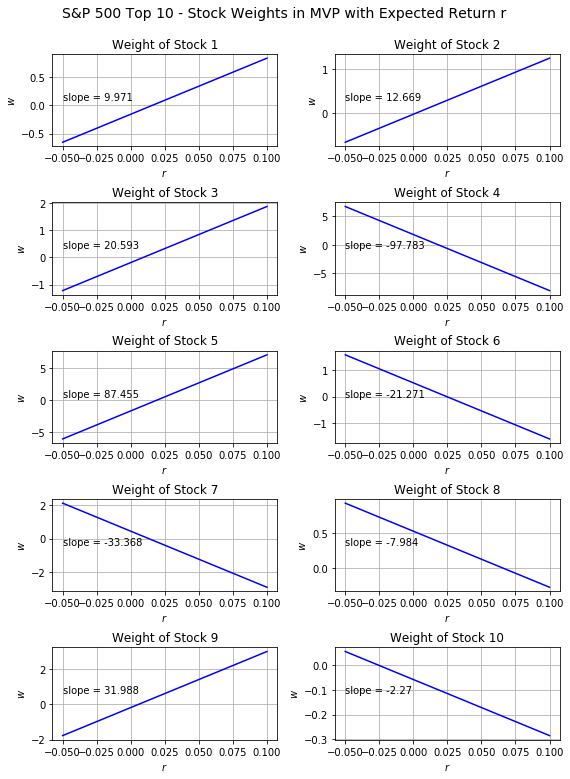

[  9.971024  12.668635  20.593066 -97.782697  87.455228 -21.271387
 -33.368333  -7.983613  31.988396  -2.270319]


In [9]:
r_min = -0.05
r_max = 0.1

size = int((r_max-r_min)*1000+1)
r_grid = np.linspace(r_min,r_max,size)
w_grid = np.ndarray(shape=(len(r_grid),10))

for i in range(len(r_grid)):
    w_grid[i] = min_var_portfolio(sp500_t10_10y,r_grid[i])

plt.figure(figsize=(8,11))

for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(r_grid,w_grid[:,i],c='b')
    dwdr = (w_grid[-1,i]-w_grid[0,i])/(r_grid[-1]-r_grid[0])
    plt.annotate("slope = "+str(np.round(dwdr,3)),(-0.05,(w_grid[-1,i]+w_grid[0,i])/2))
    plt.title("Weight of Stock "+str(i+1))
    plt.xlabel("$r$")
    plt.ylabel("$w$")
    plt.grid()

plt.suptitle("S&P 500 Top 10 - Stock Weights in MVP with Expected Return r",size=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(r"C:\Users\zhubr\Desktop\ECON 251\figures\dwdr.png")
plt.show()

data = sp500_t10_10y
e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(data)
dwdr = (C_inv@(q_ee*m-q_me*e))/(q_ee*q_mm-q_em*q_me)
print(np.round(dwdr,6))

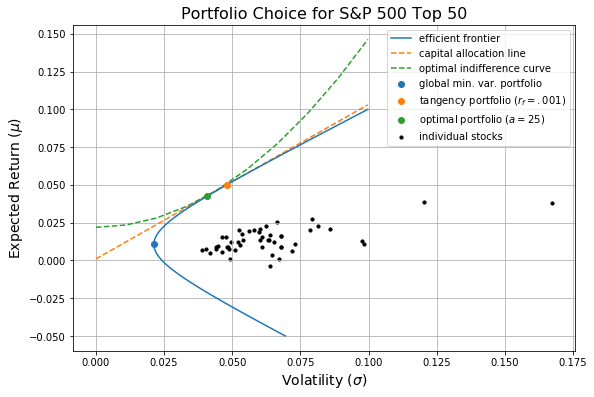

In [10]:
data = sp500_t50_10y

e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(data)

r_f = 0.001
alpha = 25

r_min = -0.05
r_max = 0.1
r_grid, v_grid = efficient_frontier(data,r_min,r_max)

r_gmv = global_min_var_portfolio_stats(data)[0]
v_gmv = global_min_var_portfolio_stats(data)[1]

r_tan = tangency_portfolio_stats(data,r_f)[0]
v_tan = tangency_portfolio_stats(data,r_f)[1]

v_min = 0
v_max = max(v_grid)
cal_v_grid = np.linspace(v_min,v_max,2)
cal_r_grid = max_sharpe_ratio(data,r_f)*cal_v_grid+r_f

r_opt = optimal_portfolio_stats(data,r_f,alpha)[0]
v_opt = optimal_portfolio_stats(data,r_f,alpha)[1]

u_opt = r_opt-alpha*v_opt**2/2
idc_v_grid = np.linspace(v_min,v_max,int((v_max-v_min)*100+1))
idc_r_grid = u_opt+alpha*idc_v_grid**2/2

plt.figure(figsize=(9,6))
plt.plot(v_grid,r_grid,label="efficient frontier",zorder=10)
plt.plot(cal_v_grid,cal_r_grid,ls='--',label="capital allocation line")
plt.plot(idc_v_grid,idc_r_grid,ls='--',label="optimal indifference curve")
plt.scatter(v_gmv,r_gmv,label="global min. var. portfolio")
plt.scatter(v_tan,r_tan,label="tangency portfolio $(r_f=.001)$",zorder=11)
plt.scatter(v_opt,r_opt,label="optimal portfolio $(a=25)$",zorder=12)
plt.scatter(v,m,c='k',s=10,label="individual stocks")
plt.title("Portfolio Choice for S&P 500 Top 50",size=16)
plt.xlabel("Volatility ($\sigma$)",size=14)
plt.ylabel("Expected Return ($\mu$)",size=14)
plt.grid()
plt.legend()
plt.savefig(r"C:\Users\zhubr\Desktop\ECON 251\figures\sp500-pc.png")
plt.show()

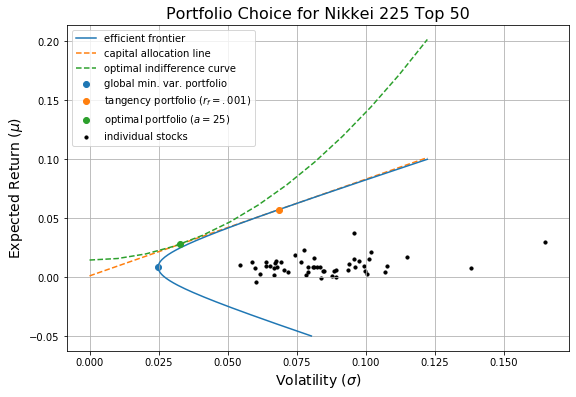

In [11]:
data = nk225_t50_10y

e, m, v, C, C_inv, q_ee, q_em, q_me, q_mm = important_values(data)

r_f = 0.001
alpha = 25

r_min = -0.05
r_max = 0.1
r_grid, v_grid = efficient_frontier(data,r_min,r_max)

r_gmv = global_min_var_portfolio_stats(data)[0]
v_gmv = global_min_var_portfolio_stats(data)[1]

r_tan = tangency_portfolio_stats(data,r_f)[0]
v_tan = tangency_portfolio_stats(data,r_f)[1]

v_min = 0
v_max = max(v_grid)
cal_v_grid = np.linspace(v_min,v_max,2)
cal_r_grid = max_sharpe_ratio(data,r_f)*cal_v_grid+r_f

r_opt = optimal_portfolio_stats(data,r_f,alpha)[0]
v_opt = optimal_portfolio_stats(data,r_f,alpha)[1]

u_opt = r_opt-alpha*v_opt**2/2
idc_v_grid = np.linspace(v_min,v_max,int((v_max-v_min)*100+1))
idc_r_grid = u_opt+alpha*idc_v_grid**2/2

plt.figure(figsize=(9,6))
plt.plot(v_grid,r_grid,label="efficient frontier",zorder=10)
plt.plot(cal_v_grid,cal_r_grid,ls='--',label="capital allocation line")
plt.plot(idc_v_grid,idc_r_grid,ls='--',label="optimal indifference curve")
plt.scatter(v_gmv,r_gmv,label="global min. var. portfolio")
plt.scatter(v_tan,r_tan,label="tangency portfolio $(r_f=.001)$",zorder=11)
plt.scatter(v_opt,r_opt,label="optimal portfolio $(a=25)$",zorder=12)
plt.scatter(v,m,c='k',s=10,label="individual stocks")
plt.title("Portfolio Choice for Nikkei 225 Top 50",size=16)
plt.xlabel("Volatility ($\sigma$)",size=14)
plt.ylabel("Expected Return ($\mu$)",size=14)
plt.grid()
plt.legend()
plt.savefig(r"C:\Users\zhubr\Desktop\ECON 251\figures\nk225-pc.png")
plt.show()

In [12]:
print(np.round(min_var_portfolio_stats(sp500_t10_10y,0.02),6))
print(np.round(min_var_portfolio_stats(sp500_t25_10y,0.02),6))
print(np.round(min_var_portfolio_stats(sp500_t50_10y,0.02),6))
print(np.round(min_var_portfolio_stats(sp500_t100_10y,0.02),6))
print(np.round(min_var_portfolio_stats(nk225_t10_10y,0.02),6))
print(np.round(min_var_portfolio_stats(nk225_t25_10y,0.02),6))
print(np.round(min_var_portfolio_stats(nk225_t50_10y,0.02),6))
print(np.round(min_var_portfolio_stats(nk225_t100_10y,0.02),6))

[0.02     0.041359]
[0.02     0.033146]
[0.02     0.023591]
[0.02     0.010106]
[0.02     0.055201]
[0.02     0.036751]
[0.02    0.02913]
[0.02     0.015629]


In [13]:
print(np.round(global_min_var_portfolio_stats(sp500_t10_10y),6))
print(np.round(global_min_var_portfolio_stats(sp500_t25_10y),6))
print(np.round(global_min_var_portfolio_stats(sp500_t50_10y),6))
print(np.round(global_min_var_portfolio_stats(sp500_t100_10y),6))
print(np.round(global_min_var_portfolio_stats(nk225_t10_10y),6))
print(np.round(global_min_var_portfolio_stats(nk225_t25_10y),6))
print(np.round(global_min_var_portfolio_stats(nk225_t50_10y),6))
print(np.round(global_min_var_portfolio_stats(nk225_t100_10y),6))

[0.010094 0.031024]
[0.008483 0.026214]
[0.010654 0.021275]
[0.011351 0.008618]
[0.011832 0.044076]
[0.007772 0.030858]
[0.008408 0.02487 ]
[0.003505 0.011972]


In [14]:
print(np.round(tangency_portfolio_stats(sp500_t10_10y,0.001),6))
print(np.round(tangency_portfolio_stats(sp500_t25_10y,0.001),6))
print(np.round(tangency_portfolio_stats(sp500_t50_10y,0.001),6))
print(np.round(tangency_portfolio_stats(sp500_t100_10y,0.001),6))
print(np.round(tangency_portfolio_stats(nk225_t10_10y,0.001),6))
print(np.round(tangency_portfolio_stats(nk225_t25_10y,0.001),6))
print(np.round(tangency_portfolio_stats(nk225_t50_10y,0.001),6))
print(np.round(tangency_portfolio_stats(nk225_t100_10y,0.001),6))

[0.023978 0.049315]
[0.038083 0.058355]
[0.050069 0.047964]
[0.030617 0.014577]
[0.022665 0.062333]
[0.060536 0.091494]
[0.057183 0.068491]
[0.157744 0.094706]


In [15]:
print(np.round(max_sharpe_ratio(sp500_t10_10y,0.001),6))
print(np.round(max_sharpe_ratio(sp500_t25_10y,0.001),6))
print(np.round(max_sharpe_ratio(sp500_t50_10y,0.001),6))
print(np.round(max_sharpe_ratio(sp500_t100_10y,0.001),6))
print(np.round(max_sharpe_ratio(nk225_t10_10y,0.001),6))
print(np.round(max_sharpe_ratio(nk225_t25_10y,0.001),6))
print(np.round(max_sharpe_ratio(nk225_t50_10y,0.001),6))
print(np.round(max_sharpe_ratio(nk225_t100_10y,0.001),6))

0.465939
0.63548
1.023031
2.031756
0.347565
0.650706
0.820292
1.65506


In [16]:
print(np.round(optimal_portfolio_stats(sp500_t10_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(sp500_t25_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(sp500_t50_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(sp500_t100_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(nk225_t10_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(nk225_t25_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(nk225_t50_10y,0.001,25),6))
print(np.round(optimal_portfolio_stats(nk225_t100_10y,0.001,25),6))

[0.009684 0.018638]
[0.017153 0.025419]
[0.042864 0.040921]
[0.166121 0.08127 ]
[0.005832 0.013903]
[0.017937 0.026028]
[0.027915 0.032812]
[0.110569 0.066202]


In [17]:
print(np.round(optimal_utility(sp500_t10_10y,0.001,25),6))
print(np.round(optimal_utility(sp500_t25_10y,0.001,25),6))
print(np.round(optimal_utility(sp500_t50_10y,0.001,25),6))
print(np.round(optimal_utility(sp500_t100_10y,0.001,25),6))
print(np.round(optimal_utility(nk225_t10_10y,0.001,25),6))
print(np.round(optimal_utility(nk225_t25_10y,0.001,25),6))
print(np.round(optimal_utility(nk225_t50_10y,0.001,25),6))
print(np.round(optimal_utility(nk225_t100_10y,0.001,25),6))

0.005342
0.009077
0.021932
0.083561
0.003416
0.009468
0.014458
0.055784
